In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Dict, Callable

### optimization

In [2]:
class SGD:
    def __init__(self, lr:float=0.01):
        self.lr: float = lr
    
    def update(self, params: Dict, grads: npt.NDArray[np.float64]):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [3]:
class Momentum:
    def __init__(self, lr:float=0.01, momentum:float=0.9):
        self.lr: float = lr
        self.momentum: float = momentum
        self.v: npt.NDArray[np.float64] = None

    def update(self, params: Dict, grads: Dict):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [4]:
class AdaGrad:
    def __init__(self, lr:float=0.01):
        self.lr: float = lr
        self.h: Dict = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [5]:
# The Adam optimizer motivates from 'Momentum' and 'RMSProp'. 
# So the Adam optimizer can accelerate the gradient descent algorithm and use an adaptive learning for each parameter.
class Adam:
    def __init__(lr:float=0.001, beta1:float=0.9, beta2:float=0.999):
        self.lr: float = lr
        self.beta1: float = beta1
        self.beta2: float = beta2
        self.iter: int = 0
        self.m: Dict = None
        self.v: Dict = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### optimizer's performance (with MNIST dataset)

===========iteration:0===========
SGD:2.4949325256444403
Momentum:2.3625183168449793
AdaGrad:2.131261209190817
Adam:2.099677079592942
===========iteration:100===========
SGD:1.7781659775708323
Momentum:0.36111473170116093
AdaGrad:0.15127173042312378
Adam:0.27280663446315956
===========iteration:200===========
SGD:0.9012527864121336
Momentum:0.19121832903189884
AdaGrad:0.0866236273931865
Adam:0.15572132072981787
===========iteration:300===========
SGD:0.47465411389196205
Momentum:0.1598176262193223
AdaGrad:0.072067894897629
Adam:0.09716180718376133
===========iteration:400===========
SGD:0.4315612322065535
Momentum:0.20304359100078792
AdaGrad:0.08420265319708709
Adam:0.1275130843018337
===========iteration:500===========
SGD:0.3357243538008973
Momentum:0.11974010164982503
AdaGrad:0.04337785898504659
Adam:0.09449546679102583
===========iteration:600===========
SGD:0.3907474438208991
Momentum:0.16957127222129614
AdaGrad:0.07617343911092286
Adam:0.13135295132722344
===========iteration:700

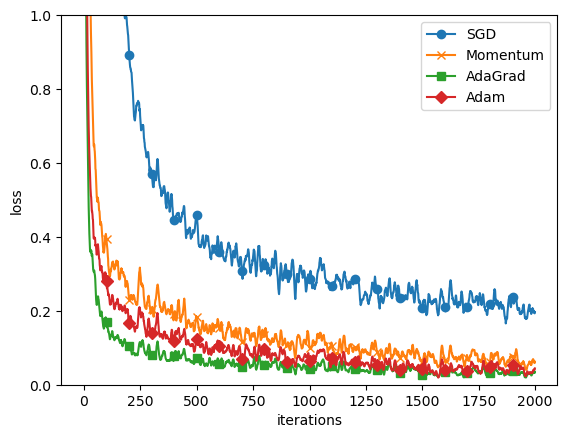

In [6]:
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### histgram of Weight initialization and Activation function

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

In [8]:
def weight_init_activation_histogram(w: npt.NDArray, w_idx: int, activation_func: Callable, acti_func_idx: int):
    input_data = np.random.randn(1000, 100)  # 1000개의 데이터

    hidden_layer_size = 5  # 은닉층이 5개
    activations = {}  # 이곳에 활성화 결과를 저장

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        z = activation_func(a)
        activations[i] = z

    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))

    # 타이틀 이름 붙이기
    title_name = ''

    if w_idx == 0:
        title_name += 'weight init : std 1, '
    elif w_idx == 1:
        title_name += 'weight init : std 0.01, '
    elif w_idx == 2:
        title_name += 'weight init : Xavier, '
    else:
        title_name += 'weight init : He, '

    if acti_func_idx == 0:
        title_name += 'activation function : sigmoid'
    elif acti_func_idx == 1:
        title_name += 'activation function : ReLU'
    else:
        title_name += 'activation function : tanh'
    
    plt.suptitle(f'< {title_name} >')

    plt.show()

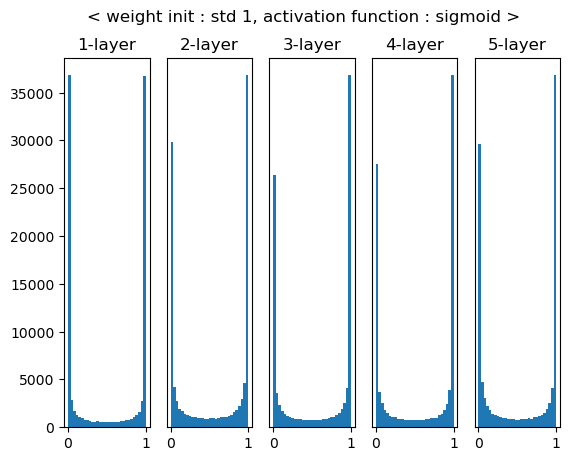

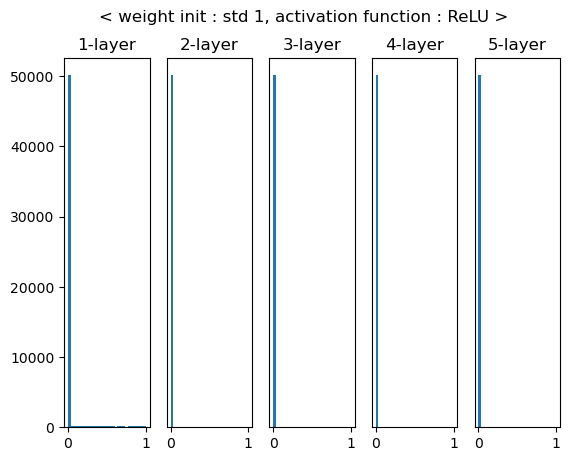

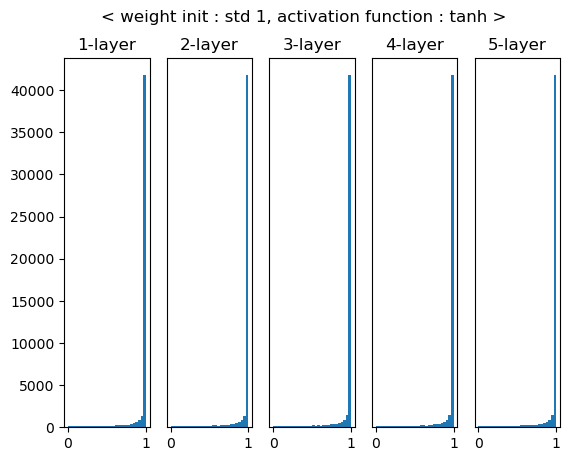

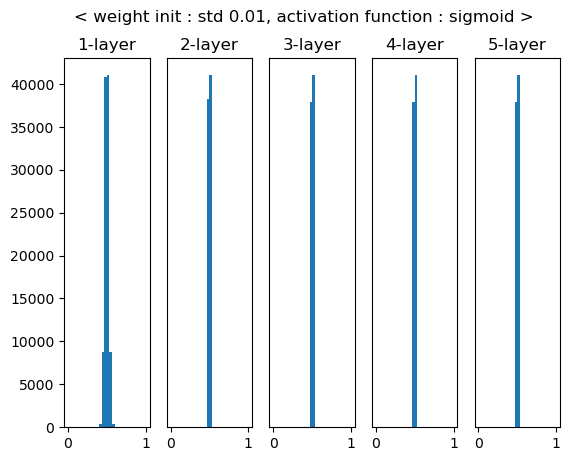

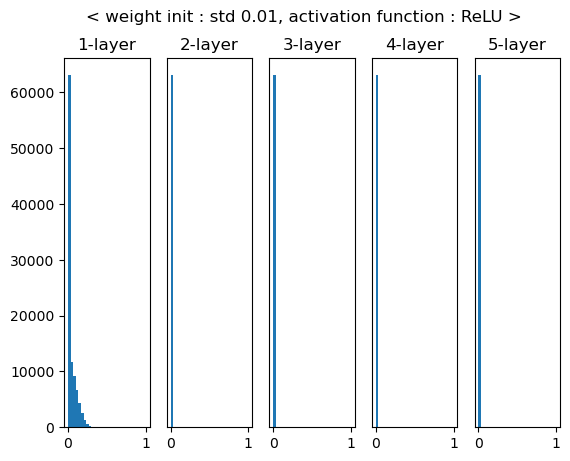

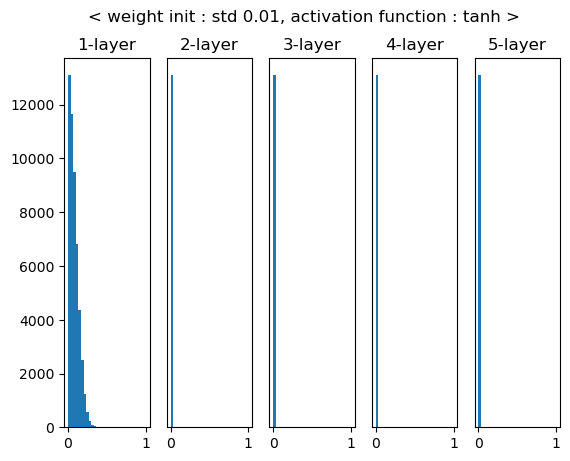

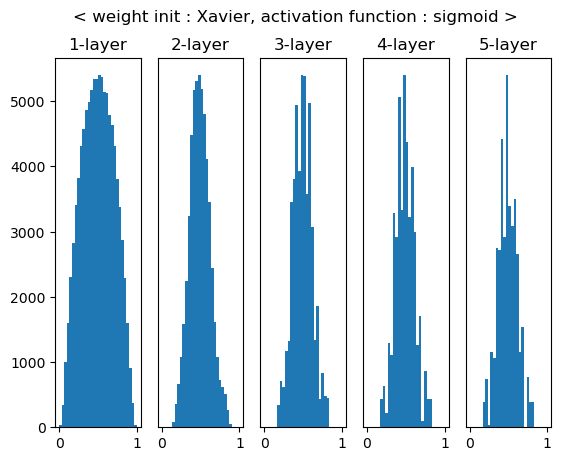

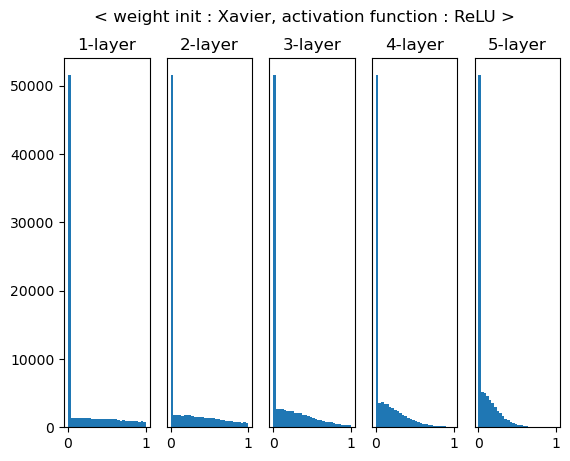

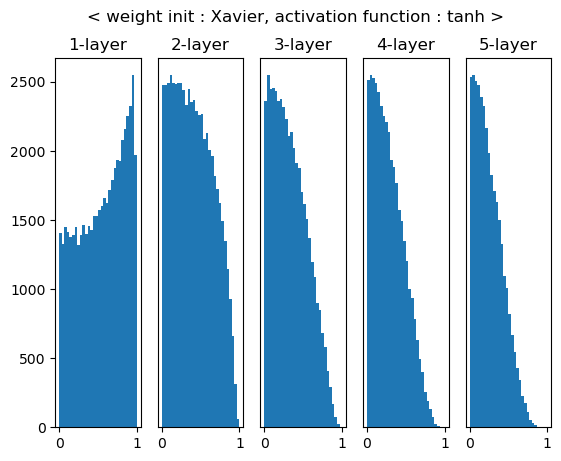

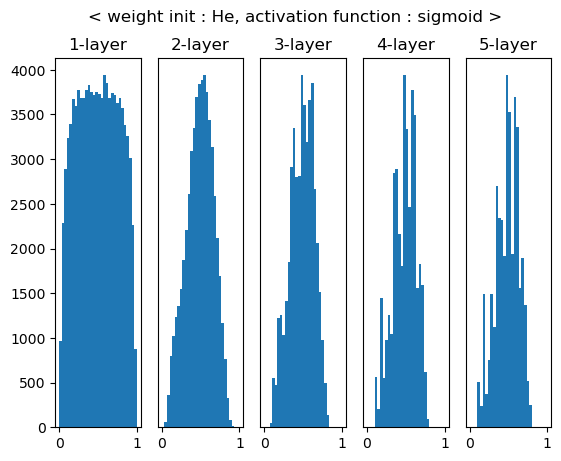

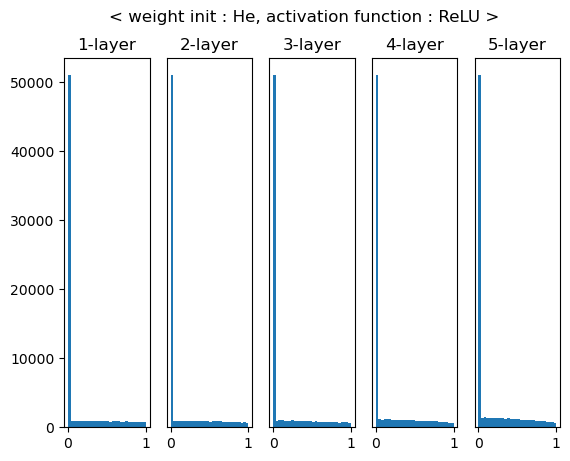

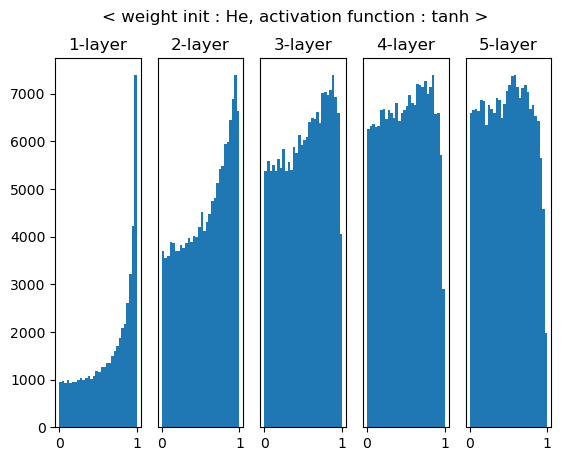

In [9]:
# 각 은닉층의 노드(뉴런) 수
node_num = 100

w_li = [np.random.randn(node_num, node_num) * 1, np.random.randn(node_num, node_num) * 0.01,
        np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num), 
        np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)]

activation_func_li = [sigmoid, ReLU, tanh]

for w_idx, w in enumerate(w_li):
    for acti_func_idx, acti_func in enumerate(activation_func_li):
        weight_init_activation_histogram(w, w_idx, acti_func, acti_func_idx)

### initialization weight's performance (with MNIST dataset)

===========iteration:0===========
std=0.01:2.3025621865291708
Xavier:2.297183923742919
He:2.3547027501497357
===========iteration:100===========
std=0.01:2.3026206358674663
Xavier:2.220859697971999
He:1.371151511700914
===========iteration:200===========
std=0.01:2.3029706333976963
Xavier:2.113379017368103
He:0.8429207322652069
===========iteration:300===========
std=0.01:2.300604202765556
Xavier:1.7829480375272353
He:0.541037384424857
===========iteration:400===========
std=0.01:2.302151539965111
Xavier:1.2488713161937302
He:0.3633914367576416
===========iteration:500===========
std=0.01:2.3039468580416087
Xavier:0.8720541797056829
He:0.34985086290982015
===========iteration:600===========
std=0.01:2.302885485022924
Xavier:0.7691488294392941
He:0.5132252412835608
===========iteration:700===========
std=0.01:2.3005642873488066
Xavier:0.6663561593308643
He:0.3611553222932434
===========iteration:800===========
std=0.01:2.3030294848882953
Xavier:0.573895813296811
He:0.31579626599279964
=

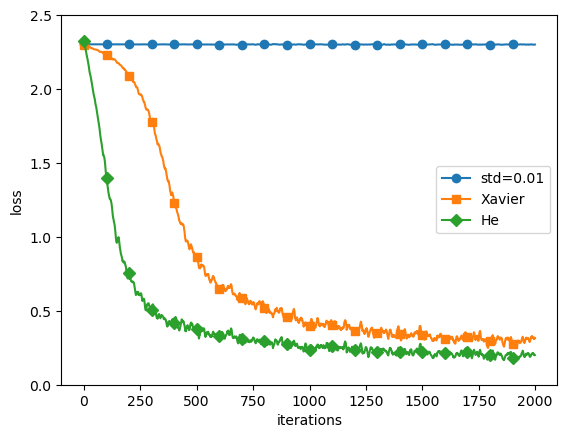

In [10]:
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### batch normalization's performance (with MNIST dataset)

============== 1/16 ==============
epoch:0 | 0.097 - 0.138
epoch:1 | 0.097 - 0.153
epoch:2 | 0.097 - 0.167
epoch:3 | 0.097 - 0.21


c:\Users\bigsm\Coding\Python\deep-learning-from-scratch-01\chapter_06\..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
c:\Users\bigsm\Coding\Python\deep-learning-from-scratch-01\chapter_06\..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in scalar multiply
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:4 | 0.097 - 0.237
epoch:5 | 0.097 - 0.249
epoch:6 | 0.097 - 0.278
epoch:7 | 0.097 - 0.29
epoch:8 | 0.097 - 0.313
epoch:9 | 0.097 - 0.327
epoch:10 | 0.097 - 0.342
epoch:11 | 0.097 - 0.357
epoch:12 | 0.097 - 0.37
epoch:13 | 0.097 - 0.378
epoch:14 | 0.097 - 0.393
epoch:15 | 0.097 - 0.412
epoch:16 | 0.097 - 0.413
epoch:17 | 0.097 - 0.436
epoch:18 | 0.097 - 0.447
epoch:19 | 0.097 - 0.456
============== 2/16 ==============
epoch:0 | 0.117 - 0.097
epoch:1 | 0.097 - 0.098
epoch:2 | 0.097 - 0.109
epoch:3 | 0.097 - 0.158


c:\Users\bigsm\Coding\Python\deep-learning-from-scratch-01\chapter_06\..\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:4 | 0.097 - 0.196
epoch:5 | 0.097 - 0.237
epoch:6 | 0.097 - 0.264
epoch:7 | 0.097 - 0.276
epoch:8 | 0.097 - 0.29
epoch:9 | 0.097 - 0.324
epoch:10 | 0.097 - 0.328
epoch:11 | 0.097 - 0.348
epoch:12 | 0.097 - 0.372
epoch:13 | 0.097 - 0.394
epoch:14 | 0.097 - 0.395
epoch:15 | 0.097 - 0.424
epoch:16 | 0.097 - 0.433
epoch:17 | 0.097 - 0.459
epoch:18 | 0.097 - 0.476
epoch:19 | 0.097 - 0.491
============== 3/16 ==============
epoch:0 | 0.099 - 0.09
epoch:1 | 0.268 - 0.115
epoch:2 | 0.425 - 0.152
epoch:3 | 0.554 - 0.183
epoch:4 | 0.624 - 0.226
epoch:5 | 0.696 - 0.261
epoch:6 | 0.744 - 0.305
epoch:7 | 0.78 - 0.34
epoch:8 | 0.81 - 0.365
epoch:9 | 0.86 - 0.4
epoch:10 | 0.877 - 0.429
epoch:11 | 0.905 - 0.443
epoch:12 | 0.925 - 0.468
epoch:13 | 0.931 - 0.486
epoch:14 | 0.945 - 0.518
epoch:15 | 0.953 - 0.539
epoch:16 | 0.958 - 0.567
epoch:17 | 0.972 - 0.584
epoch:18 | 0.977 - 0.601
epoch:19 | 0.978 - 0.61
============== 4/16 ==============
epoch:0 | 0.079 - 0.086
epoch:1 | 0.218 - 0.154
epoch:2

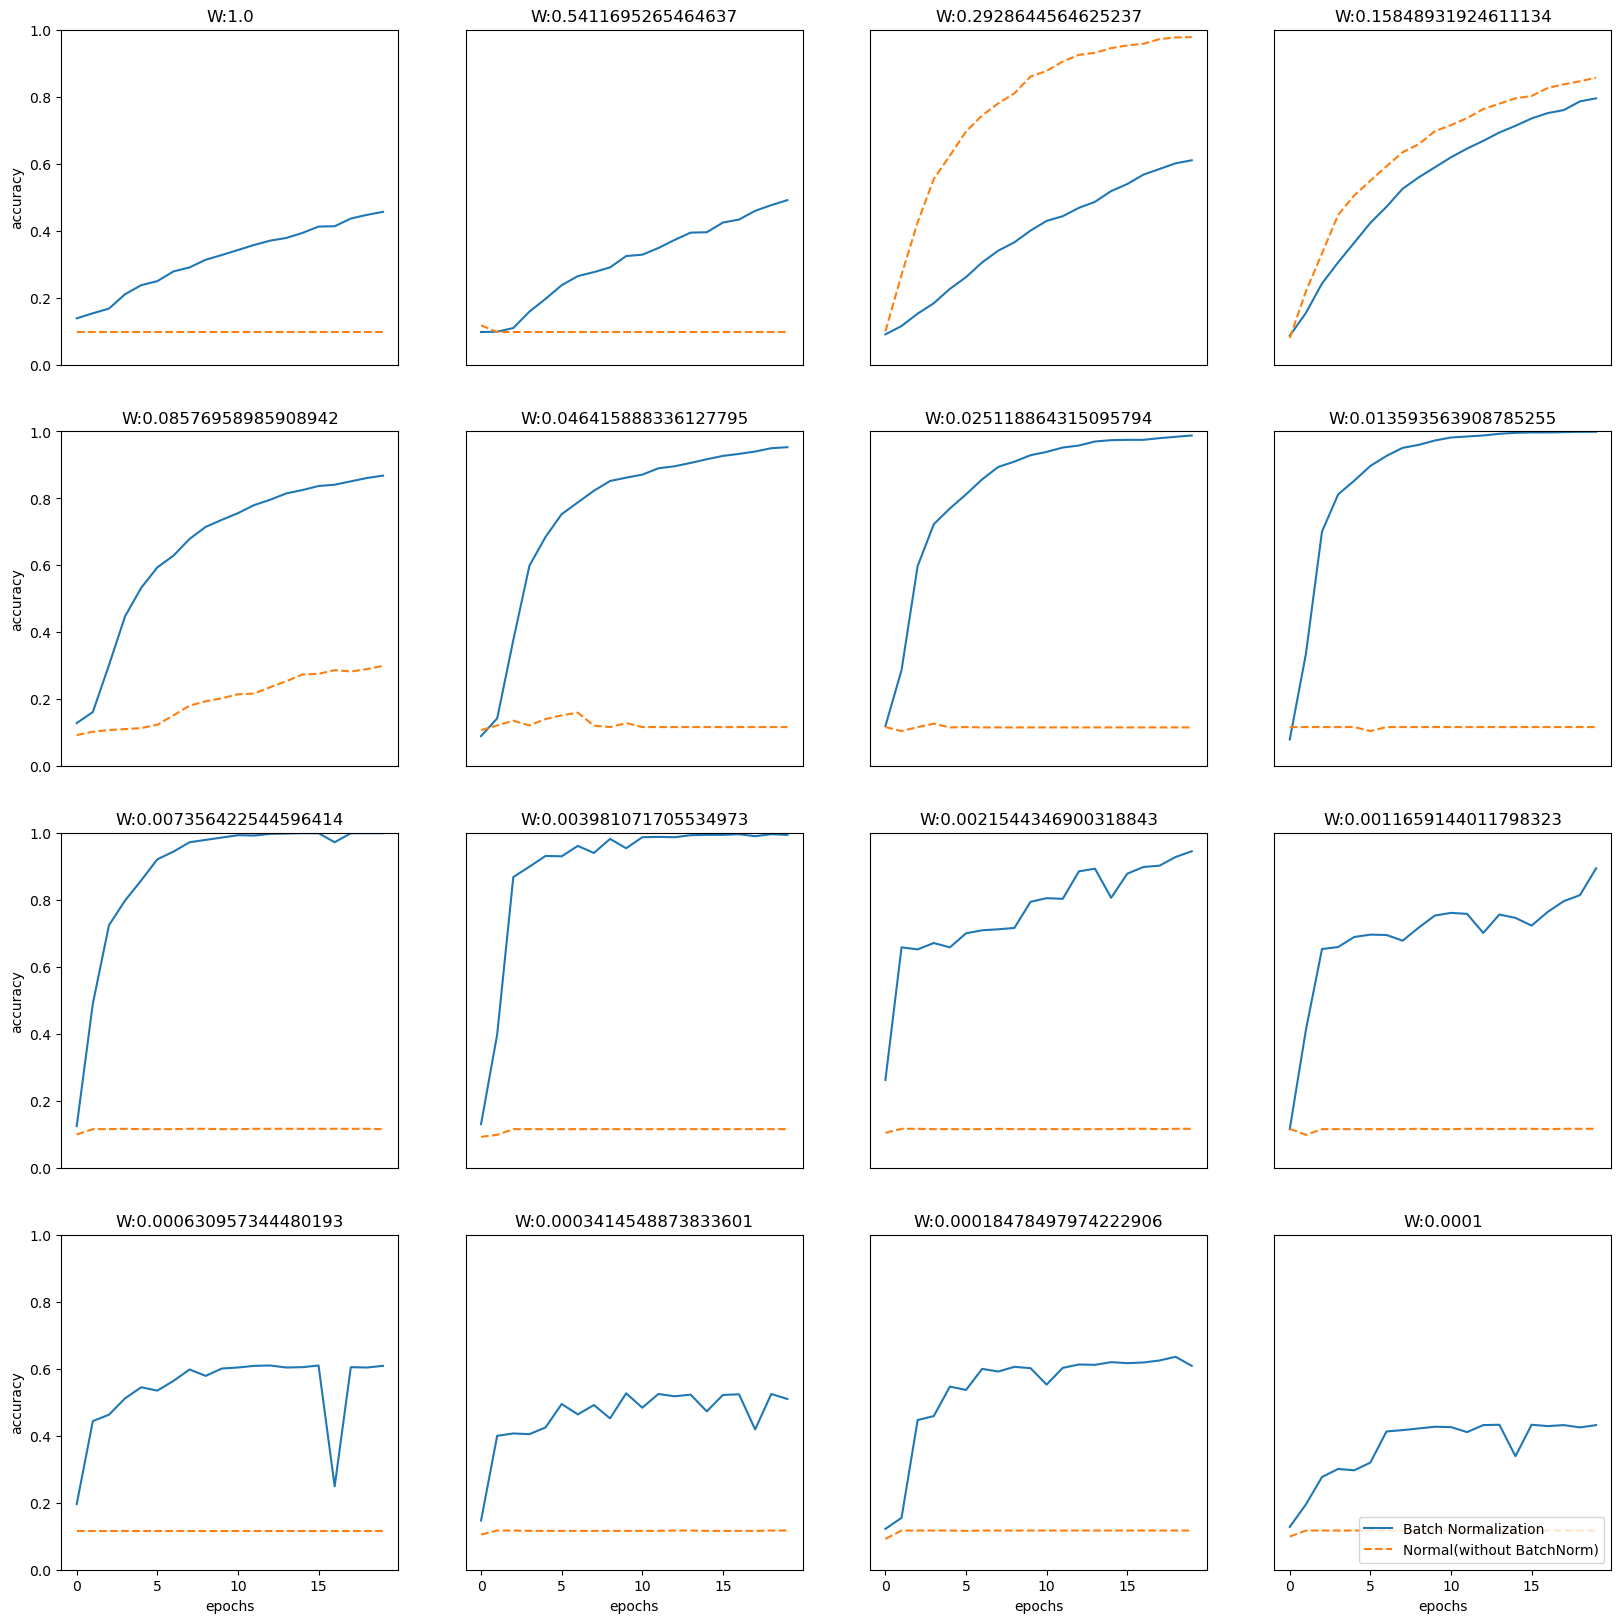

In [11]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(20,20))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    
plt.legend(loc='lower right')    
plt.show()